In [266]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import holidays

In [267]:
# Load your time series data
df = pd.read_csv('LSTM Dataset.csv')
df.tail(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc
14595,Sunday,12/31/2023,19:00,31.12.2023 19.00.00,1681.0,1,0,0.0,No Rain
14596,Sunday,12/31/2023,20:00,31.12.2023 20.00.00,297.0,1,0,0.0,No Rain
14597,Sunday,12/31/2023,21:00,31.12.2023 21.00.00,0.0,1,0,0.0,No Rain
14598,Sunday,12/31/2023,22:00,31.12.2023 22.00.00,0.0,1,0,0.0,No Rain
14599,Sunday,12/31/2023,23:00,31.12.2023 23.00.00,0.0,1,0,0.0,No Rain


In [268]:
ph_holidays = holidays.PH()
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x in ph_holidays else 0)
df.head(5)

,Day,Date,Time,DateAndTime,Entry,is_weekend,rain_class,rain_amount,rain_desc,is_holiday
0,Saturday,1/1/2022,4:00,01.01.2022 04.00.00,0.0,1,0,0.0,No Rain,1
1,Saturday,1/1/2022,5:00,01.01.2022 05.00.00,0.0,1,0,0.0,No Rain,1
2,Saturday,1/1/2022,6:00,01.01.2022 06.00.00,525.0,1,0,0.0,No Rain,1
3,Saturday,1/1/2022,7:00,01.01.2022 07.00.00,610.0,1,0,0.0,No Rain,1
4,Saturday,1/1/2022,8:00,01.01.2022 08.00.00,684.0,1,0,0.0,No Rain,1


In [269]:
df.drop(['Date', 'Time', 'rain_amount', 'rain_desc'], axis=1, inplace=True)
df.head(31)

,Day,DateAndTime,Entry,is_weekend,rain_class,is_holiday
0,Saturday,01.01.2022 04.00.00,0.0,1,0,1
1,Saturday,01.01.2022 05.00.00,0.0,1,0,1
2,Saturday,01.01.2022 06.00.00,525.0,1,0,1
3,Saturday,01.01.2022 07.00.00,610.0,1,0,1
4,Saturday,01.01.2022 08.00.00,684.0,1,0,1
5,Saturday,01.01.2022 09.00.00,770.0,1,0,1
6,Saturday,01.01.2022 10.00.00,1022.0,1,0,1
7,Saturday,01.01.2022 11.00.00,1248.0,1,0,1
8,Saturday,01.01.2022 12.00.00,1048.0,1,0,1
9,Saturday,01.01.2022 13.00.00,1199.0,1,0,1


In [270]:
df['Date Time'] = pd.to_datetime(df['DateAndTime'], format='%d.%m.%Y %H.%M.%S')
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year
df.drop(['DateAndTime', 'Day', 'is_weekend'], axis=1, inplace=True)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

model_features = ['hour', 'day_of_week', 'is_weekend', 'month', 'year', 'rain_class', 'Entry']
df_model = df[model_features]

df.head(50)

,Entry,rain_class,is_holiday,Date Time,hour,day_of_week,month,year,is_weekend
0,0.0,0,1,2022-01-01 04:00:00,4,5,1,2022,1
1,0.0,0,1,2022-01-01 05:00:00,5,5,1,2022,1
2,525.0,0,1,2022-01-01 06:00:00,6,5,1,2022,1
3,610.0,0,1,2022-01-01 07:00:00,7,5,1,2022,1
4,684.0,0,1,2022-01-01 08:00:00,8,5,1,2022,1
5,770.0,0,1,2022-01-01 09:00:00,9,5,1,2022,1
6,1022.0,0,1,2022-01-01 10:00:00,10,5,1,2022,1
7,1248.0,0,1,2022-01-01 11:00:00,11,5,1,2022,1
8,1048.0,0,1,2022-01-01 12:00:00,12,5,1,2022,1
9,1199.0,0,1,2022-01-01 13:00:00,13,5,1,2022,1


In [271]:
# Display the DataFrame before normalization
print(df_model.head())
print(df_model.dtypes)

   hour  day_of_week  is_weekend  month  year  rain_class  Entry
0     4            5           1      1  2022           0    0.0
1     5            5           1      1  2022           0    0.0
2     6            5           1      1  2022           0  525.0
3     7            5           1      1  2022           0  610.0
4     8            5           1      1  2022           0  684.0
hour             int32
day_of_week      int32
is_weekend       int64
month            int32
year             int32
rain_class       int64
Entry          float64
dtype: object


In [272]:
from sklearn.preprocessing import MinMaxScaler
import joblib
# Normalize all features except 'Entry'
scaler = MinMaxScaler(feature_range=(0, 1))
df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])

# Save the scaler for the features
joblib.dump(scaler, 'model/scaler_features.pkl')

# Normalize the 'Entry' column separately
scaler_entry = MinMaxScaler(feature_range=(0, 1))
df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])

# Save the scaler for the 'Entry' column
joblib.dump(scaler_entry, 'model/scaler_entry.pkl')

# Display the DataFrame after normalization
print("After normalization:")
print(df_model.head())
print(df_model.dtypes)

After normalization:
       hour  day_of_week  is_weekend  month  year  rain_class     Entry
0  0.000000     0.833333         1.0    0.0   0.0         0.0  0.000000
1  0.052632     0.833333         1.0    0.0   0.0         0.0  0.000000
2  0.105263     0.833333         1.0    0.0   0.0         0.0  0.082121
3  0.157895     0.833333         1.0    0.0   0.0         0.0  0.095417
4  0.210526     0.833333         1.0    0.0   0.0         0.0  0.106992
hour           float64
day_of_week    float64
is_weekend     float64
month          float64
year           float64
rain_class     float64
Entry          float64
dtype: object


C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_16340\2928577659.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_16340\2928577659.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

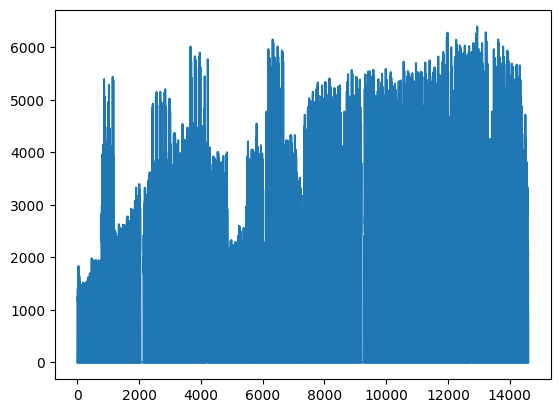

In [273]:
entry = df['Entry']
entry.plot()

In [274]:
def df_to_X_y(df, window_size=19):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][6]  # 'Entry' is the 7th column (index 6)
        y.append(label)
    return np.array(X), np.array(y)

In [275]:
X, y = df_to_X_y(df_model)
X.shape, y.shape

((14581, 19, 7), (14581,))

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.75, random_state=42)
X_val, X_remaining, y_val, y_remaining = train_test_split(X_temp, y_temp, test_size=0.8333, random_state=42)
X_test, y_test = X, y
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3645, 19, 7), (3645,), (1823, 19, 7), (1823,), (14581, 19, 7), (14581,))

In [277]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [278]:
model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 19, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

In [279]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])


Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0573 - val_loss: 0.0320
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0274 - val_loss: 0.0237
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0218 - val_loss: 0.0133
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0127 - val_loss: 0.0062
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 12/100
114/114 ━━━━━━━━━

In [280]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go

# Extract the 'Date Time' column for the entire dataset
date_time_test = df['Date Time']

# Load the scaler for inverse transformation
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Make predictions on the test set
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y_test, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_test_inv = scaler_entry.inverse_transform(df_actual)

# Ensure date_time_test matches the length of y_test_inv and y_pred_inv
date_time_test = date_time_test[-len(y_test_inv):]

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_test_inv = np.round(np.maximum(y_test_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=date_time_test, y=y_test_inv.flatten(), mode='lines', name='Actual Values'))
fig.add_trace(go.Scatter(x=date_time_test, y=y_pred_inv.flatten(), mode='lines', name='Predicted Values'))

fig.update_layout(
    title='LSTM Model Forecast vs Actual Values',
    xaxis_title='Date Time',
    yaxis_title='Entry',
    legend_title='Legend'
)

fig.show()

456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Root Mean Squared Error (RMSE): 247.77209205545375
Mean Absolute Error (MAE): 163.432343460668
R-squared (R²): 0.9639086916421563


In [281]:
# Inverse transform the actual values
df_actual = pd.DataFrame(y_test, columns=['Entry'])
y_test_inv = scaler_entry.inverse_transform(df_actual)

# Ensure date_time_test matches the length of y_test_inv and y_pred_inv
date_time_test = df['Date Time'][-len(y_test_inv):]

# Create a DataFrame with the predictions, actual values, and corresponding is_holiday and rain_class
df_pred_with_time = pd.DataFrame({
    'Date Time': date_time_test,
    'Actual Entry': y_test_inv.flatten(),
    'Forecasted Entry': y_pred_inv.flatten(),
    'is_holiday': df['is_holiday'][-len(y_test_inv):].values,  # Add is_holiday to the DataFrame
    'rain_class': df['rain_class'][-len(y_test_inv):].values   # Add rain_class to the DataFrame
})

# Extract the hour from the 'Date Time' column
df_pred_with_time['hour'] = df_pred_with_time['Date Time'].dt.hour

# Aggregate the actual and predicted values by hour
hourly_trend = df_pred_with_time.groupby('hour').agg({
    'Actual Entry': 'mean',
    'Forecasted Entry': 'mean'
}).reset_index()

# Display the aggregated data
print(hourly_trend)

import plotly.express as px

# Create a Plotly figure for the hourly trend based on actual and predicted values
fig = px.line(hourly_trend, x='hour', y=['Actual Entry', 'Forecasted Entry'], title='Hourly Trend of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Average Entry',
    legend_title='Legend'
)


# Show the plot
fig.show()

    hour  Actual Entry  Forecasted Entry
0      4     13.554184         76.894379
1      5   1992.597165       1927.087769
2      6   3063.263603       3017.795654
3      7   3670.468907       3562.441650
4      8   3230.871056       3210.050781
5      9   2801.925926       2677.064453
6     10   2414.137860       2467.223633
7     11   2397.104024       2320.836670
8     12   2385.529721       2266.421143
9     13   2299.090992       2274.913574
10    14   2290.140832       2335.545898
11    15   2425.228624       2497.866943
12    16   2794.812757       2761.915039
13    17   3113.893004       3045.887451
14    18   2990.024234       3087.580322
15    19   2714.909465       2714.330566
16    20   2218.021491       2248.124756
17    21   1572.274577       1582.244141
18    22     84.217421        143.677643
19    23      9.768721        102.099998


In [282]:
# Extract the day of the week from the 'Date Time' column
df_pred_with_time['day_of_week'] = df_pred_with_time['Date Time'].dt.dayofweek

# Aggregate the actual and predicted values by day of the week
daily_trend = df_pred_with_time.groupby('day_of_week').agg({
    'Actual Entry': 'mean',
    'Forecasted Entry': 'mean'
}).reset_index()

# Map day_of_week numbers to day names, starting with Sunday
day_names = {6: 'Sunday', 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday'}
daily_trend['day_name'] = daily_trend['day_of_week'].map(day_names)

# Reorder the DataFrame to start with Sunday
daily_trend = daily_trend.set_index('day_of_week').loc[[6, 0, 1, 2, 3, 4, 5]].reset_index()

# Display the aggregated data
print(daily_trend)

# Create a Plotly figure for the daily trend based on actual and predicted values
fig = px.line(daily_trend, x='day_name', y=['Actual Entry', 'Forecasted Entry'], title='Daily Trend of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Average Entry',
    legend_title='Legend'
)

# Show the plot
fig.show()

   day_of_week  Actual Entry  Forecasted Entry   day_name
0            6   1845.407937       1867.911377     Sunday
1            0   2369.341106       2349.469238     Monday
2            1   2396.994792       2382.884521    Tuesday
3            2   2372.536619       2354.230713  Wednesday
4            3   2267.686218       2277.269775   Thursday
5            4   2313.039183       2276.192383     Friday
6            5   2006.317556       2006.474243   Saturday


In [283]:
# Extract the month from the 'Date Time' column
df_pred_with_time['month'] = df_pred_with_time['Date Time'].dt.month

# Aggregate the actual and predicted values by month
monthly_trend = df_pred_with_time.groupby('month').agg({
    'Actual Entry': 'sum',
    'Forecasted Entry': 'sum'
}).reset_index()

# Map month numbers to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
monthly_trend['month_name'] = monthly_trend['month'].map(month_names)

# Display the aggregated data
print(monthly_trend)

# Create a Plotly figure for the monthly trend based on actual and predicted values
fig = px.line(monthly_trend, x='month_name', y=['Actual Entry', 'Forecasted Entry'], title='Monthly Trend of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Average Entry',
    legend_title='Legend'
)

# Show the plot
fig.show()

    month  Actual Entry  Forecasted Entry month_name
0       1  2.025910e+06         2005149.0    January
1       2  2.557536e+06         2512018.0   February
2       3  2.479618e+06         2469393.0      March
3       4  2.212421e+06         2220791.0      April
4       5  3.029230e+06         3018230.0        May
5       6  2.900718e+06         2899887.0       June
6       7  3.164846e+06         3150683.0       July
7       8  2.844917e+06         2850886.0     August
8       9  2.353626e+06         2369020.0  September
9      10  2.791251e+06         2807705.0    October
10     11  3.143098e+06         3097316.0   November
11     12  2.924095e+06         2908306.0   December


In [284]:
# Calculate mean and standard deviation for holidays and non-holidays
mean_holiday = df[df['is_holiday'] == 1]['Entry'].mean()
std_holiday = df[df['is_holiday'] == 1]['Entry'].std()
mean_non_holiday = df[df['is_holiday'] == 0]['Entry'].mean()
std_non_holiday = df[df['is_holiday'] == 0]['Entry'].std()

print(f"Holiday - Mean: {mean_holiday}, Std Dev: {std_holiday}")
print(f"Non-Holiday - Mean: {mean_non_holiday}, Std Dev: {std_non_holiday}")

Holiday - Mean: 1566.4734126976225, Std Dev: 1204.845559602335
Non-Holiday - Mean: 2262.230559593546, Std Dev: 1299.610236071554


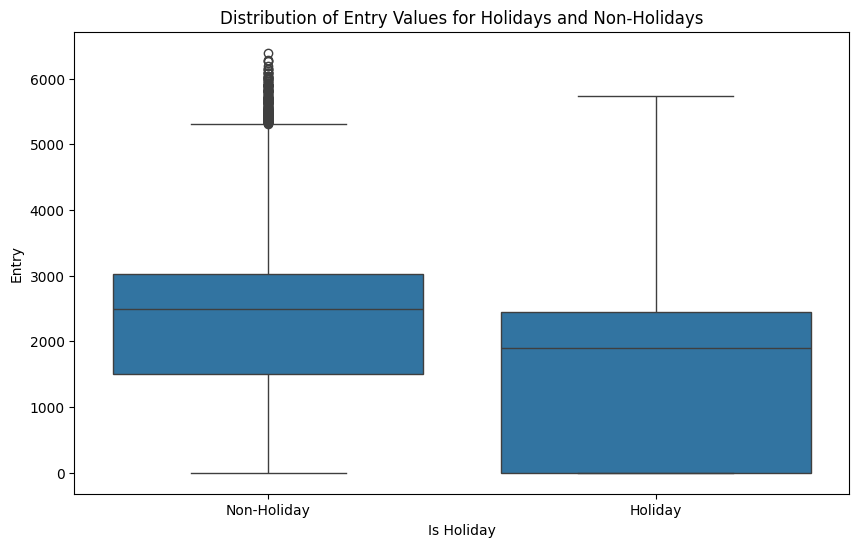

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot to visualize the distribution of Entry values for holidays and non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Entry', data=df)
plt.title('Distribution of Entry Values for Holidays and Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Entry')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [286]:
from scipy.stats import ttest_ind

# Perform t-test
holiday_entries = df[df['is_holiday'] == 1]['Entry']
non_holiday_entries = df[df['is_holiday'] == 0]['Entry']

t_stat, p_value = ttest_ind(holiday_entries, non_holiday_entries, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between holidays and non-holidays.")

T-statistic: -16.172073238245833, P-value: 3.2099421304437347e-52
Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.


In [287]:
# Calculate mean and standard deviation for each rain_class
rain_class_stats = df.groupby('rain_class')['Entry'].agg(['mean', 'std']).reset_index()
print(rain_class_stats)

   rain_class         mean          std
0           0  2145.033235  1300.077212
1           1  2189.014583  1294.567424
2           2  2384.725820  1307.742238
3           3  2244.148837  1302.094956
4           4  2103.780864  1270.273438
5           5  1112.050000   613.758265


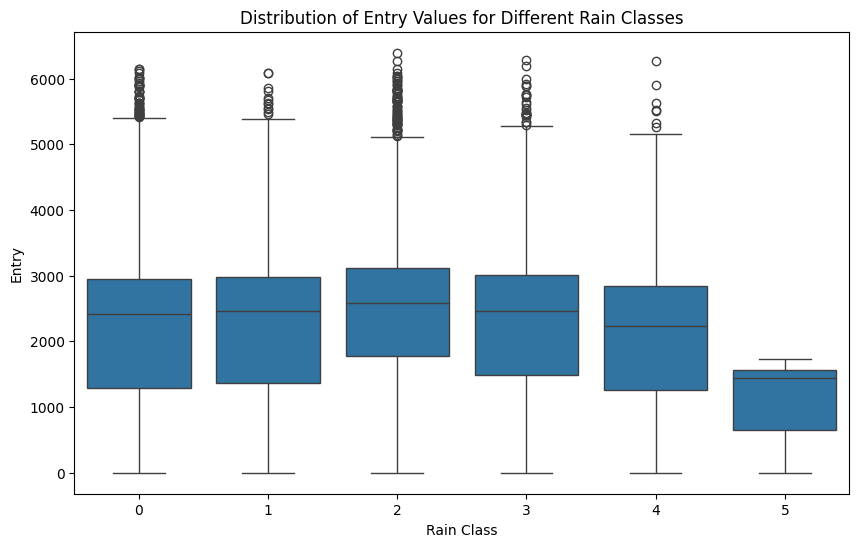

F-statistic: 20.975342571662864, P-value: 5.907390644949e-21
Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.


In [288]:
# Box plot to visualize the distribution of Entry values for different rain classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_class', y='Entry', data=df)
plt.title('Distribution of Entry Values for Different Rain Classes')
plt.xlabel('Rain Class')
plt.ylabel('Entry')
plt.show()

from scipy.stats import f_oneway

# Perform ANOVA
rain_class_groups = [df[df['rain_class'] == rc]['Entry'] for rc in df['rain_class'].unique()]
f_stat, p_value = f_oneway(*rain_class_groups)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between different rain classes.")

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     0      1    43.9813 0.8164    -56.992  144.9547  False
     0      2   239.6926    0.0    164.987  314.3982   True
     0      3    99.1156 0.0538    -0.9123  199.1435  False
     0      4   -41.2524 0.9808  -206.9189  124.4142  False
     0      5 -1032.9832 0.0052 -1862.6727 -203.2938   True
     1      2   195.7112    0.0    87.4189  304.0035   True
     1      3    55.1343  0.819   -71.9558  182.2243  False
     1      4   -85.2337  0.771  -268.5141   98.0466  False
     1      5 -1076.9646 0.0032 -1910.3498 -243.5794   True
     2      3   -140.577 0.0026  -247.9883  -33.1656   True
     2      4   -280.945    0.0  -451.1713 -110.7186   True
     2      5 -1272.6758 0.0002 -2103.2878 -442.0639   True
     3      4   -140.368 0.2428  -323.1292   42.3933  False
     3      5 -1132.0988 0.0015   -1965.

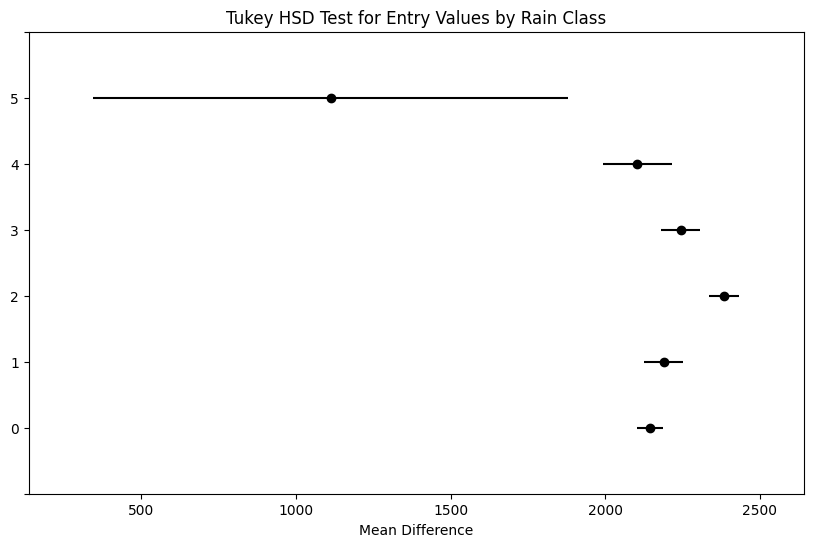

In [289]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Entry'], groups=df['rain_class'], alpha=0.05)
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test for Entry Values by Rain Class')
plt.xlabel('Mean Difference')
plt.show()

In [290]:
import numpy as np
import pandas as pd
from datetime import timedelta

# Function to forecast the next month
def forecast_next_month(model, last_data, n_steps=30):
    future_predictions = []
    current_input = last_data.copy()

    # Get the last date from your dataset
    last_date = df['Date Time'].iloc[-1]

    for i in range(n_steps):
        # Reshape the current input to match model input shape
        current_input_reshaped = current_input.reshape(1, current_input.shape[0], current_input.shape[1])
        
        # Make prediction for the next time step
        prediction = model.predict(current_input_reshaped)
        future_predictions.append(prediction[0, 0])
        raw_predictions = model.predict(current_input_reshaped)
        print(raw_predictions)  # Check the raw output from the model

        # Update the date for the next input
        next_date = last_date + timedelta(days=i + 1)
        
        # Prepare features for the next time step
        next_hour = next_date.hour
        next_day_of_week = next_date.dayofweek
        next_is_weekend = 1 if next_day_of_week >= 5 else 0  # 1 for Saturday/Sunday
        next_month = next_date.month
        next_year = next_date.year
        
        # Construct the new input with the predicted Entry
        current_input = np.append(current_input[1:], [[next_hour, next_day_of_week, next_is_weekend, next_month, next_year, rain_class_placeholder, prediction[0, 0]]], axis=0)
        
    return future_predictions


In [291]:
# Get the last available input data (last window size of your dataset)
last_data = df_model.tail(window_size).to_numpy()

# Placeholder for rain_class (you may need a strategy for this; here we use a constant or mode)
rain_class_placeholder = 0  # Adjust this based on your dataset logic

# Forecast the next month (30 days)
n_days = 31  # Forecast for the next 30 days
predicted_entries = forecast_next_month(model, last_data, n_steps=n_days)

# Inverse transform the predictions
predicted_entries_inv = scaler_entry.inverse_transform(np.array(predicted_entries).reshape(-1, 1))

# Create a DataFrame to hold the predictions along with dates
future_dates = pd.date_range(start=df['Date Time'].iloc[-1] + timedelta(days=1), periods=n_days, freq='D')
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Entry': predicted_entries_inv.flatten()})

# Display the forecast
print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[-0.02700458]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.08211243]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.07113728]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.06263925]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.06080216]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.06439336]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.06994049]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.06994399]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.06983162]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.06986797]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[0.06988826

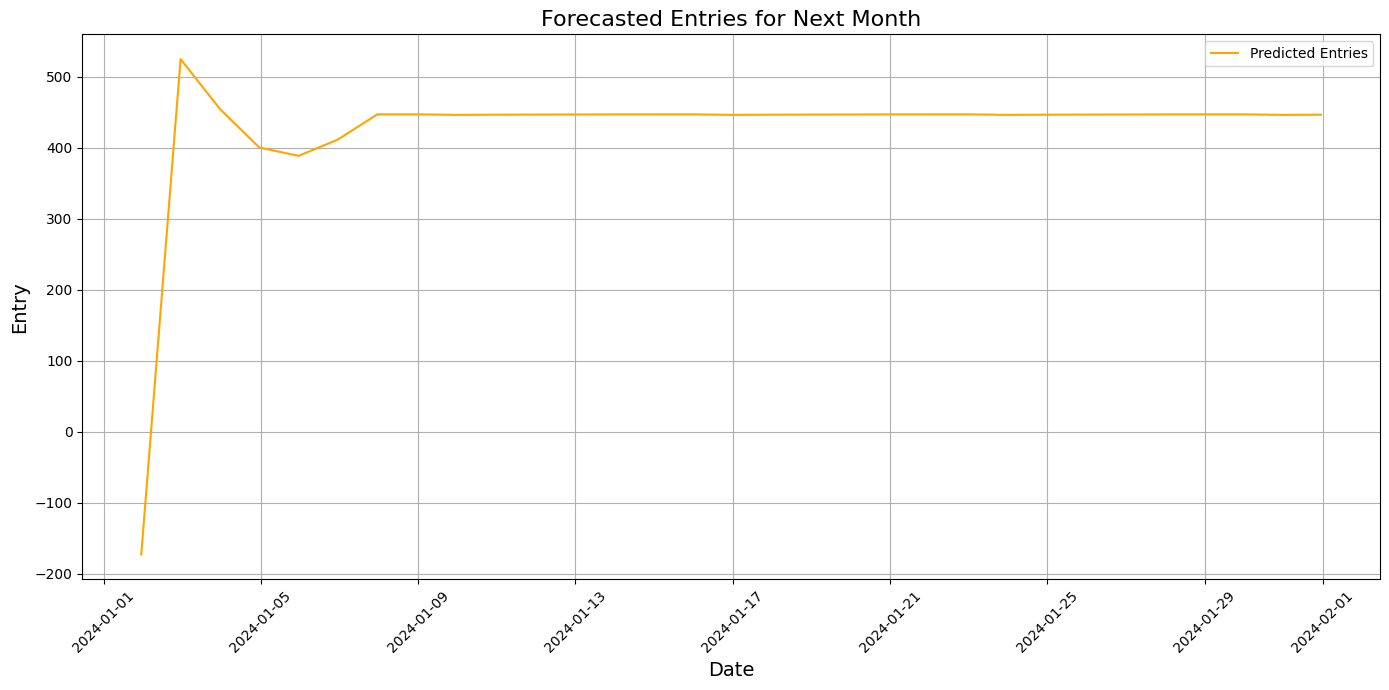

In [292]:

# Create a plot for the predicted entries
plt.figure(figsize=(14, 7))

# Plot only predicted entries
plt.plot(future_dates, predicted_entries_inv.flatten(), label='Predicted Entries', color='orange')

# Add titles and labels
plt.title('Forecasted Entries for Next Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Entry', fontsize=14)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
